# Integrantes
- Daniel Diab
- Laura Martinez

# 1. Preparación Datos
## 1.1. Importar Librerias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

## 1.2. Cargar Datos

In [2]:
df = pd.read_csv('./data.csv', sep=',', header=0)
datos = df.copy()

## 1.3. Eliminar Duplicados

In [3]:
import pandas as pd

def corregir_fechas(df, col="Date of Service"):
    df = df.copy()

    s = df[col].astype("string").str.strip()
    s = s.replace({"": pd.NA, "nan": pd.NA, "NaN": pd.NA, "null": pd.NA, "None": pd.NA})

    # pandas moderno: resuelve formatos mixtos de forma fiable
    try:
        dt = pd.to_datetime(s, errors="coerce", format="mixed", dayfirst=True)
    except TypeError:
        dt = pd.to_datetime(s, errors="coerce", dayfirst=True)
        m = dt.isna() & s.notna()
        dt.loc[m] = pd.to_datetime(s[m], errors="coerce", dayfirst=False)

    df[col] = dt.dt.normalize() #solo fecha, no hora
    return df

datos = corregir_fechas(datos, "Date of Service")
print("Fechas inválidas:", datos["Date of Service"].isna().sum())

Fechas inválidas: 0


In [4]:
print("Duplicados exactos:", datos.duplicated().sum())

Duplicados exactos: 151


In [5]:
datos = datos.drop_duplicates()
datos.shape

(1488, 24)

In [6]:
cols_llave = ["Patient ID", "Date of Service"]

conflict_keys = datos.loc[
    datos.duplicated(subset=cols_llave, keep=False), cols_llave].drop_duplicates()

print("Llaves conflictivas:", len(conflict_keys))

datos = datos.merge(conflict_keys, on=cols_llave, how="left", indicator=True)
datos = datos[datos["_merge"] == "left_only"].drop(columns="_merge")

print("Filas restantes:", len(datos))

Llaves conflictivas: 112
Filas restantes: 1264


In [7]:
# Variable objetivo
target = "CVD Risk Score"

print("Filas antes de eliminar NaN en target:", len(datos))
print("NaN en target:", datos[target].isna().sum())

# Eliminar filas sin variable objetivo
datos = datos.dropna(subset=[target]).copy()

print("Filas después de eliminar NaN en target:", len(datos))
print("NaN en target ahora:", datos[target].isna().sum())

Filas antes de eliminar NaN en target: 1264
NaN en target: 27
Filas después de eliminar NaN en target: 1237
NaN en target ahora: 0


## 1.4. Separar Dataset

In [8]:
from sklearn.model_selection import train_test_split

X = datos.drop(columns=["CVD Risk Score", "CVD Risk Level"], errors="ignore")
y = datos["CVD Risk Score"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## 1.5. Pipeline

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer

In [10]:
cols_to_drop = ["Patient ID", "Date of Service", "CVD Risk Level", "Blood Pressure (mmgHg)"]

def drop_columns(df):
    return df.drop(columns=cols_to_drop, errors="ignore")

dropper = FunctionTransformer(drop_columns)

In [11]:
def _to_num(s):
    return pd.to_numeric(s, errors="coerce")

def completar_bp_desde_texto(df, col_bp_texto="Blood Pressure (mmHg)", col_sis="Systolic BP", col_dia="Diastolic BP"):
    df = df.copy()
    if col_bp_texto not in df.columns:
        return df

    s = df[col_bp_texto].astype("string").str.strip()
    extra = s.str.extract(r"^\s*(\d+)\s*/\s*(\d+)\s*$")
    sys = _to_num(extra[0])
    dia = _to_num(extra[1])

    if col_sis in df.columns:
        m = df[col_sis].isna() & sys.notna()
        df.loc[m, col_sis] = sys.loc[m]

    if col_dia in df.columns:
        m = df[col_dia].isna() & dia.notna()
        df.loc[m, col_dia] = dia.loc[m]

    return df

tr_completar_bp = FunctionTransformer(completar_bp_desde_texto)


def corregir_swap_bp(df, col_sis="Systolic BP", col_dia="Diastolic BP"):
    df = df.copy()
    if col_sis not in df.columns or col_dia not in df.columns:
        return df

    sis = _to_num(df[col_sis])
    dia = _to_num(df[col_dia])

    m = sis.notna() & dia.notna() & (dia > sis)
    if m.any():
        df.loc[m, col_sis], df.loc[m, col_dia] = dia.loc[m].values, sis.loc[m].values

    return df

tr_swap_bp = FunctionTransformer(corregir_swap_bp)


def completar_altura_m_cm(df, col_h_m="Height (m)", col_h_cm="Height (cm)"):
    df = df.copy()
    if col_h_m not in df.columns or col_h_cm not in df.columns:
        return df

    hm = _to_num(df[col_h_m])
    hcm = _to_num(df[col_h_cm])

    # si falta cm y hay m
    m1 = hm.notna() & hcm.isna()
    df.loc[m1, col_h_cm] = hm.loc[m1] * 100

    # si falta m y hay cm
    m2 = hm.isna() & hcm.notna()
    df.loc[m2, col_h_m] = hcm.loc[m2] / 100

    return df

tr_altura_completar = FunctionTransformer(completar_altura_m_cm)


def resolver_inconsistencia_altura(df, col_h_m="Height (m)", col_h_cm="Height (cm)", tol_cm=1.0):
    df = df.copy()
    if col_h_m not in df.columns or col_h_cm not in df.columns:
        return df

    hm = _to_num(df[col_h_m])
    hcm = _to_num(df[col_h_cm])

    m = hm.notna() & hcm.notna() & (abs(hcm - hm * 100) > tol_cm)
    if m.any():
        df.loc[m, col_h_cm] = hm.loc[m] * 100

    return df

tr_altura_resolver = FunctionTransformer(resolver_inconsistencia_altura)


def recalcular_bmi(df, col_peso="Weight", col_h_m="Height (m)", col_bmi="BMI"):
    df = df.copy()
    if col_peso not in df.columns or col_h_m not in df.columns or col_bmi not in df.columns:
        return df

    w = _to_num(df[col_peso])
    hm = _to_num(df[col_h_m])

    m = w.notna() & hm.notna() & (hm > 0)
    df.loc[m, col_bmi] = w.loc[m] / (hm.loc[m] ** 2)

    return df

tr_bmi = FunctionTransformer(recalcular_bmi)


def recalcular_waist_height_ratio(df, col_cintura="Abdominal Circumference (cm)", col_h_cm="Height (cm)", col_ratio="Waist-to-Height Ratio"):
    df = df.copy()
    if col_cintura not in df.columns or col_h_cm not in df.columns or col_ratio not in df.columns:
        return df

    cintura = _to_num(df[col_cintura])
    hcm = _to_num(df[col_h_cm])

    m = cintura.notna() & hcm.notna() & (hcm > 0)
    df.loc[m, col_ratio] = cintura.loc[m] / hcm.loc[m]

    return df

tr_ratio = FunctionTransformer(recalcular_waist_height_ratio)

def clip_iqr_array(X, factor=1.5):
    X = np.asarray(X, dtype=float)

    q1 = np.nanpercentile(X, 25, axis=0)
    q3 = np.nanpercentile(X, 75, axis=0)
    iqr = q3 - q1

    lower = q1 - factor * iqr
    upper = q3 + factor * iqr

    return np.clip(X, lower, upper)

clipper_transformer = FunctionTransformer(clip_iqr_array)

In [12]:
numeric_features = [
    "Age",
    "Weight (kg)",
    "Height (m)",
    "Height (cm)",
    "BMI",
    "Abdominal Circumference (cm)",
    "Waist-to-Height Ratio",
    "Systolic BP",
    "Diastolic BP",
    "Total Cholesterol (mg/dL)",
    "HDL (mg/dL)",
    "Estimated LDL (mg/dL)",
    "Fasting Blood Sugar (mg/dL)",
]

#Variables categóricas
binary_features = [
    "Sex",
    "Smoking Status",
    "Diabetes Status",
    "Family History of CVD",
]

ordinal_features = [
    "Physical Activity Level",
]

nominal_features = [
    "Blood Pressure Category",
]

In [13]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),
    ("clipper", clipper_transformer),
    ("scaler", StandardScaler()),
])

binary_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(drop="if_binary", handle_unknown="ignore")),
])

ordinal_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ordinal", OrdinalEncoder(categories=[["Low", "Moderate", "High"]])),
])

nominal_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])

In [14]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("bin", binary_transformer, binary_features),
        ("ord", ordinal_transformer, ordinal_features),
        ("nom", nominal_transformer, nominal_features),
    ],
    remainder="drop"
)

In [15]:
from sklearn.pipeline import Pipeline

pipeline_preparacion = Pipeline(steps=[
    ("bp_fill", tr_completar_bp),
    ("dropper", dropper),

    # determinísticas (en el orden correcto)
    ("bp_swap", tr_swap_bp),
    ("h_fill", tr_altura_completar),
    ("h_fix", tr_altura_resolver),
    ("bmi", tr_bmi),
    ("ratio", tr_ratio),

    # no determinísticas (aprenden en fit): imputación + clipping + escalado + encoding
    ("preprocesamiento", preprocessor),
])

pipeline_preparacion

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('bp_fill', ...), ('dropper', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"func func: callable, default=NoneThe callable to use for the transformation. This will be passedthe same arguments as transform, with args and kwargs forwarded.If func is None, then func will be the identity function.",<function com...t 0x114bc2e80>
,"inverse_func inverse_func: callable, default=NoneThe callable to use for the inverse transformation. This will bepassed the same arguments as inverse transform, with args andkwargs forwarded. If inverse_func is None, then inverse_funcwill be the identity function.",None
,"validate validate: bool, default=FalseIndicate that the input X array should be checked before calling``func``. The possibilities are:- If False, there is no input validation.- If True, then X will be converted to a 2-dimensional NumPy array or sparse matrix. If the conversion is not possible an exception is raised... versionchanged:: 0.22 The default of ``validate`` changed from True to False.",False
,"accept_sparse accept_sparse: bool, default=FalseIndicate that func accepts a sparse matrix as input. If validate isFalse, this has no effect. Otherwise, if accept_sparse is false,sparse matrix inputs will cause an exception to be raised.",False
,"check_inverse check_inverse: bool, default=TrueWhether to check that or ``func`` followed by ``inverse_func`` leads tothe original inputs. It can be used for a sanity check, raising awarning when the condition is not fulfilled... versionadded:: 0.20",True
,"feature_names_out feature_names_out: callable, 'one-to-one' or None, default=NoneDetermines the list of feature names that will be returned by the`get_feature_names_out` method. If it is 'one-to-one', then the outputfeature names will be equal to the input feature names. If it is acallable, then it must take two positional arguments: this`FunctionTransformer` (`self`) and an array-like of input feature names(`input_features`). It must return an array-like of output featurenames. The `get_feature_names_out` method is only defined if`feature_names_out` is not None.See ``get_feature_names_out`` for more details... versionadded:: 1.1",None
,"kw_args kw_args: dict, default=NoneDictionary of additional keyword arguments to pas

In [16]:
from sklearn.linear_model import LinearRegression

pipeline_regresion = Pipeline(steps=[
    ("preparacion", pipeline_preparacion),
    ("modelo", LinearRegression())
])

pipeline_regresion

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preparacion', ...), ('modelo', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('bp_fill', ...), ('dropper', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"func func: callable, default=NoneThe callable to use for the transformation. This will be passedthe same arguments as transform, with args and kwargs forwarded.If func is None, then func will be the identity function.",<function com...t 0x114bc2e80>
,"inverse_func inverse_func: callable, default=NoneThe callable to use for the inverse t

In [17]:
pipeline_regresion.fit(X_train, y_train)

modelo = pipeline_regresion.named_steps["modelo"]
print("Número de coeficientes:", len(modelo.coef_))

Número de coeficientes: 22


In [18]:
y_train_pred = pipeline_regresion.predict(X_train)
y_test_pred  = pipeline_regresion.predict(X_test)

In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def reporte_metricas(y_true, y_pred, nombre=""):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    print(f"--- {nombre} ---")
    print(f"MAE:  {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R2:   {r2:.4f}")
    print()

reporte_metricas(y_train, y_train_pred, "Train")
reporte_metricas(y_test, y_test_pred, "Test")

--- Train ---
MAE:  3.1365
RMSE: 10.7059
R2:   0.0755

--- Test ---
MAE:  3.0179
RMSE: 10.2431
R2:   0.0124



In [20]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(927, 22)
(927,)
(310, 22)
(310,)


## Polinomial
Con el fin de poder continunar con las actividades, empezaremos por contruri un moedo polinomial.

In [21]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV

Para poder comenzar realizaremos un nuevo pipeline para la polinomial.

In [22]:
pipeline_polinomial = Pipeline(steps=[
    ("preparacion", pipeline_preparacion),
    ("poly", PolynomialFeatures(include_bias=False)),
    ("modelo", LinearRegression())
])

Para evaluar cómo influye la complejidad del modelo en su desempeño, se realizará una búsqueda del grado del polinomio utilizando GridSearchCV con validación cruzada.

El grado controla la flexibilidad del modelo: valores bajos generan modelos más simples, mientras que valores altos permiten capturar relaciones más complejas.

Mediante validación cruzada se seleccionará automáticamente el grado que obtenga mejor desempeño promedio en términos de RMSE, evitando elegirlo de forma arbitraria.

In [24]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

param_grid = {
    "poly__degree": [1, 2, 3, 4],  
    "scaler": ["passthrough", StandardScaler(), MinMaxScaler()]
}

grid = GridSearchCV(
    estimator=pipeline_polinomial,
    param_grid=param_grid,
    cv=3,  
    scoring="neg_root_mean_squared_error",
    n_jobs=1  
)

grid.fit(X_train, y_train)

print("Mejores hiperparámetros:", grid.best_params_)
print("Mejor RMSE (CV):", -grid.best_score_)

mejor_modelo = grid.best_estimator_

y_pred_train = mejor_modelo.predict(X_train)
y_pred_test  = mejor_modelo.predict(X_test)

rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
mae_train  = mean_absolute_error(y_train, y_pred_train)
r2_train   = r2_score(y_train, y_pred_train)

rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
mae_test  = mean_absolute_error(y_test, y_pred_test)
r2_test   = r2_score(y_test, y_pred_test)

print("\n--- TRAIN ---")
print("RMSE:", rmse_train)
print("MAE :", mae_train)
print("R2  :", r2_train)

print("\n--- TEST ---")
print("RMSE:", rmse_test)
print("MAE :", mae_test)
print("R2  :", r2_test)

Mejores hiperparámetros: {'poly__degree': 1, 'scaler': MinMaxScaler()}
Mejor RMSE (CV): 10.633452206366359

--- TRAIN ---
RMSE: 10.705935778566696
MAE : 3.1364856528338114
R2  : 0.07550772352359669

--- TEST ---
RMSE: 10.243055313616054
MAE : 3.0179218728498527
R2  : 0.012371174791017903


El mejor modelo encontrado corresponde a un polinomio de grado 1, lo que sugiere que incrementar la complejidad no mejora el desempeño bajo validación cruzada. Además, la cercanía entre los errores de entrenamiento y prueba indica ausencia de sobreajuste; sin embargo, el R² en prueba es muy bajo, lo cual sugiere limitada capacidad explicativa con las variables actuales.

## Curvas de validación

Con el fin de analizar cómo la complejidad del modelo afecta su desempeño, se generan curvas de validación en función del grado del polinomio.

Para cada grado, se calcula el error promedio en validación cruzada junto con su desviación estándar, lo que permite evaluar tanto el desempeño medio como la variabilidad del modelo.

Esto permite identificar el punto a partir del cual aumentar la complejidad comienza a producir sobreajuste, en términos del trade-off sesgo-varianza.

In [ ]:
from sklearn.model_selection import cross_val_score

grados = [1, 2, 3, 4, 5]

rmse_mean = []
rmse_std = []
rmse_train = []

for d in grados:
    
    modelo = Pipeline(steps=[
        ("preparacion", pipeline_preparacion),
        ("poly", PolynomialFeatures(degree=d, include_bias=False)),
        ("modelo", LinearRegression())
    ])
    
    scores = cross_val_score(
        modelo,
        X_train,
        y_train,
        cv=3,
        scoring="neg_root_mean_squared_error"
    )
    
    rmse_mean.append(-scores.mean())
    rmse_std.append(scores.std())
    
    # error de entrenamiento
    modelo.fit(X_train, y_train)
    y_train_pred = modelo.predict(X_train)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_train.append(train_rmse)

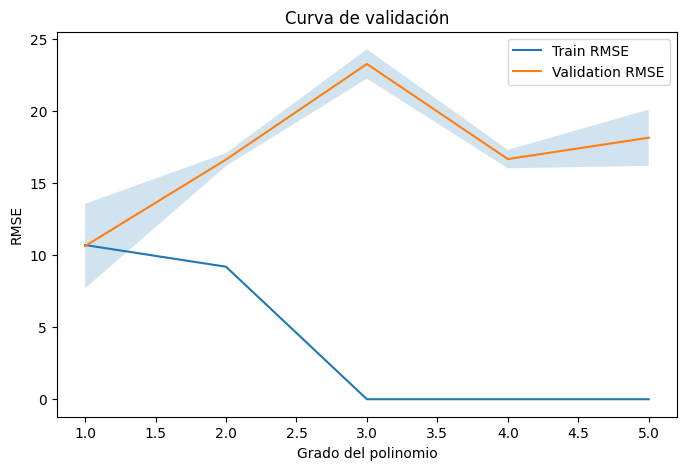

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))

plt.plot(grados, rmse_train, label="Train RMSE")
plt.plot(grados, rmse_mean, label="Validation RMSE")

plt.fill_between(
    grados,
    np.array(rmse_mean) - np.array(rmse_std),
    np.array(rmse_mean) + np.array(rmse_std),
    alpha=0.2
)

plt.xlabel("Grado del polinomio")
plt.ylabel("RMSE")
plt.legend()
plt.title("Curva de validación")
plt.show()

La curva de validación evidencia claramente el efecto del incremento de la complejidad del modelo. A medida que aumenta el grado del polinomio, el error de entrenamiento disminuye drásticamente, alcanzando incluso valores cercanos a cero a partir del grado 3.

Sin embargo, el error de validación aumenta considerablemente para grados mayores a 1, lo que indica que el modelo comienza a sobreajustar los datos de entrenamiento y pierde capacidad de generalización.

Este comportamiento refleja el trade-off sesgo-varianza: grados bajos presentan mayor sesgo pero estabilidad, mientras que grados altos incrementan significativamente la varianza.

El grado óptimo corresponde a 1, ya que minimiza el error de validación y mantiene una brecha reducida entre entrenamiento y validación.

## Regresión lineal regularizada (Ridge y Lasso)

Se implementan modelos de regresión lineal con regularización L2 (Ridge) y L1 (Lasso) usando pipelines.  
La regularización introduce una penalización controlada por el hiperparámetro `alpha`, que busca reducir el sobreajuste y mejorar la generalización.  
Se comparan los modelos sin regularización, Ridge y Lasso usando GridSearchCV (validación cruzada), explorando distintos valores de `alpha` y estrategias de escalamiento.  
Además, se analiza el efecto de la penalización sobre la magnitud de los coeficientes y, en Lasso, qué variables son llevadas exactamente a cero (selección automática de características).

In [27]:
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def reportar_metricas(y_train, y_pred_train, y_test, y_pred_test, nombre="Modelo"):
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    mae_train  = mean_absolute_error(y_train, y_pred_train)
    r2_train   = r2_score(y_train, y_pred_train)

    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    mae_test  = mean_absolute_error(y_test, y_pred_test)
    r2_test   = r2_score(y_test, y_pred_test)

    print(f"\n--- {nombre} ---")
    print("TRAIN -> RMSE:", rmse_train, "| MAE:", mae_train, "| R2:", r2_train)
    print("TEST  -> RMSE:", rmse_test,  "| MAE:", mae_test,  "| R2:", r2_test)


Se importan las librerías necesarias y se define una función para reportar RMSE, MAE y R² en train y test, de forma consistente para todos los modelos.

### 1. Modelo de referencia (sin regularización)

Se entrena una regresión lineal estándar como línea base para comparar el efecto de Ridge (L2) y Lasso (L1).

In [28]:
baseline = Pipeline(steps=[
    ("preparacion", pipeline_preparacion),
    ("scaler", "passthrough"),
    ("modelo", LinearRegression())
])

baseline.fit(X_train, y_train)

pred_train = baseline.predict(X_train)
pred_test  = baseline.predict(X_test)

reportar_metricas(y_train, pred_train, y_test, pred_test, "Lineal (sin regularización)")


--- Lineal (sin regularización) ---
TRAIN -> RMSE: 10.705935778566701 | MAE: 3.136485652833879 | R2: 0.07550772352359592
TEST  -> RMSE: 10.243055313616063 | MAE: 3.017921872849906 | R2: 0.012371174791016126


 ### 2. Ridge (regularización L2)

Ridge agrega una penalización L2 controlada por `alpha`, que tiende a reducir la magnitud de los coeficientes y mejorar la generalización sin llevarlos exactamente a cero.  
Se busca el mejor `alpha` con GridSearchCV y se prueban distintas estrategias de escalamiento.

In [29]:
pipeline_ridge = Pipeline(steps=[
    ("preparacion", pipeline_preparacion),
    ("scaler", "passthrough"),
    ("modelo", Ridge())
])

param_grid_ridge = {
    "scaler": ["passthrough", StandardScaler(), MinMaxScaler()],
    "modelo__alpha": np.logspace(-3, 3, 9)   # 1e-3 ... 1e3
}

grid_ridge = GridSearchCV(
    pipeline_ridge,
    param_grid_ridge,
    cv=3,
    scoring="neg_root_mean_squared_error",
    n_jobs=1
)

grid_ridge.fit(X_train, y_train)

print("Ridge mejores hiperparámetros:", grid_ridge.best_params_)
print("Ridge mejor RMSE (CV):", -grid_ridge.best_score_)

Ridge mejores hiperparámetros: {'modelo__alpha': np.float64(177.82794100389228), 'scaler': 'passthrough'}
Ridge mejor RMSE (CV): 10.528408573601325


La regularización L2 (Ridge) mostró una ligera mejora en el desempeño respecto al modelo lineal sin regularización, reduciendo el RMSE promedio en validación cruzada.

El valor óptimo de α fue aproximadamente 178, lo que indica una penalización relativamente fuerte. Esto sugiere que el modelo lineal original presentaba cierta inestabilidad en los coeficientes, la cual es mitigada mediante la contracción impuesta por Ridge.

La mejora, aunque moderada, refleja un mejor equilibrio entre ajuste y generalización.

In [30]:
mejor_ridge = grid_ridge.best_estimator_

pred_train = mejor_ridge.predict(X_train)
pred_test  = mejor_ridge.predict(X_test)

reportar_metricas(y_train, pred_train, y_test, pred_test, "Ridge (L2)")


--- Ridge (L2) ---
TRAIN -> RMSE: 10.749906377115213 | MAE: 2.902531618543392 | R2: 0.06789812117638039
TEST  -> RMSE: 10.211632222302375 | MAE: 2.739598417865425 | R2: 0.018421468782041983


El modelo Ridge (regularización L2) mostró una ligera mejora respecto a la regresión lineal sin regularización, reduciendo el RMSE y el MAE en el conjunto de prueba. El valor óptimo de α fue aproximadamente 178, lo que indica una penalización considerable sobre los coeficientes.

Esta penalización reduce la magnitud de los parámetros, estabilizando el modelo y mejorando ligeramente su capacidad de generalización. Sin embargo, el incremento en R² es marginal, lo que sugiere que la limitación principal del modelo no es el sobreajuste, sino la limitada capacidad explicativa de las variables disponibles.

En términos de sesgo-varianza, la regularización L2 reduce ligeramente la varianza sin afectar significativamente el sesgo.

### 4. Lasso (regularización L1)

Lasso agrega una penalización L1 controlada por `alpha`. A diferencia de Ridge, Lasso puede llevar coeficientes exactamente a cero, funcionando como selección automática de características.  
Se busca el mejor `alpha` con GridSearchCV y se prueban distintas estrategias de escalamiento.

In [31]:
pipeline_lasso = Pipeline(steps=[
    ("preparacion", pipeline_preparacion),
    ("scaler", "passthrough"),
    ("modelo", Lasso(max_iter=20000))
])

param_grid_lasso = {
    "scaler": ["passthrough", StandardScaler(), MinMaxScaler()],
    "modelo__alpha": np.logspace(-4, 1, 10)  # 1e-4 ... 10
}

grid_lasso = GridSearchCV(
    pipeline_lasso,
    param_grid_lasso,
    cv=3,
    scoring="neg_root_mean_squared_error",
    n_jobs=1
)

grid_lasso.fit(X_train, y_train)

print("Lasso mejores hiperparámetros:", grid_lasso.best_params_)
print("Lasso mejor RMSE (CV):", -grid_lasso.best_score_)

/Users/danieldiab/.pyenv/versions/3.13.2/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.223e+04, tolerance: 9.643e+00
  model = cd_fast.enet_coordinate_descent(
/Users/danieldiab/.pyenv/versions/3.13.2/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.154e+04, tolerance: 8.573e+00
  model = cd_fast.enet_coordinate_descent(
/Users/danieldiab/.pyenv/versions/3.13.2/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the

Lasso mejores hiperparámetros: {'modelo__alpha': np.float64(0.05994842503189409), 'scaler': MinMaxScaler()}
Lasso mejor RMSE (CV): 10.457658050319813


### Evaluación final de Lasso (L1)

Se evalúa el mejor modelo Lasso encontrado por validación cruzada en train y test para comparar contra el modelo lineal y Ridge.

In [32]:
mejor_lasso = grid_lasso.best_estimator_

pred_train = mejor_lasso.predict(X_train)
pred_test  = mejor_lasso.predict(X_test)

reportar_metricas(y_train, pred_train, y_test, pred_test, "Lasso (L1)")


--- Lasso (L1) ---
TRAIN -> RMSE: 10.756294861211545 | MAE: 3.041698128215458 | R2: 0.06678992781855597
TEST  -> RMSE: 10.131452308383668 | MAE: 2.7628842404561578 | R2: 0.03377531230832609


Se compararon tres modelos: regresión lineal sin regularización, Ridge (L2) y Lasso (L1).

El modelo sin regularización presentó un bajo poder explicativo (R² ≈ 0.01 en prueba), con errores similares en entrenamiento y prueba, lo que indica ausencia de sobreajuste pero alto sesgo.

Ridge mostró una ligera mejora en desempeño, reduciendo el RMSE y MAE en prueba. La penalización L2 contrajo los coeficientes, estabilizando el modelo y mejorando marginalmente la generalización.

Lasso presentó el mejor desempeño en el conjunto de prueba, con el menor RMSE y el mayor R². Esto sugiere que la selección automática de características introducida por la penalización L1 permitió eliminar variables irrelevantes, reduciendo la varianza del modelo y mejorando su capacidad de generalización.

En conclusión, aunque el poder explicativo global sigue siendo limitado, Lasso logró el mejor equilibrio entre complejidad y desempeño predictivo.

## Regresión polinomial regularizada 

Se implementa un modelo que combina expansión polinomial y regularización Ridge (L2).  
Se busca evaluar si, al aumentar el grado del polinomio (mayor complejidad), la penalización `alpha` permite controlar el sobreajuste y mejorar la generalización.  

Se realizará una búsqueda con GridSearchCV explorando:  
- grado del polinomio (`degree`)  
- fuerza de penalización (`alpha`)  
- estrategia de escalamiento  

In [35]:
pipeline_poly_ridge = Pipeline(steps=[
    ("preparacion", pipeline_preparacion),
    ("scaler", "passthrough"),
    ("poly", PolynomialFeatures(include_bias=False)),
    ("modelo", Ridge())
])

### Búsqueda de hiperparámetros (degree, alpha, scaler)

Se exploran grados moderados para evitar explosión de características, y valores de `alpha` en escala logarítmica para cubrir penalizaciones débiles a fuertes.

In [36]:
param_grid_poly_ridge = {
    "poly__degree": [1, 2, 3],                 
    "scaler": ["passthrough", StandardScaler(), MinMaxScaler()],
    "modelo__alpha": np.logspace(-3, 3, 7)     
}

grid_poly_ridge = GridSearchCV(
    estimator=pipeline_poly_ridge,
    param_grid=param_grid_poly_ridge,
    cv=3,
    scoring={
        "rmse": "neg_root_mean_squared_error",
        "mae": "neg_mean_absolute_error",
        "r2": "r2"
    },
    refit="rmse",   
    n_jobs=1
)

grid_poly_ridge.fit(X_train, y_train)

print("Mejores hiperparámetros:", grid_poly_ridge.best_params_)
print("Mejor RMSE (CV):", -grid_poly_ridge.best_score_)

Mejores hiperparámetros: {'modelo__alpha': np.float64(100.0), 'poly__degree': 1, 'scaler': 'passthrough'}
Mejor RMSE (CV): 10.527646199146643


In [37]:
res = grid_poly_ridge.cv_results_

idx = grid_poly_ridge.best_index_

rmse_mean = -res["mean_test_rmse"][idx]
rmse_std  =  res["std_test_rmse"][idx]

mae_mean  = -res["mean_test_mae"][idx]
mae_std   =  res["std_test_mae"][idx]

r2_mean   =  res["mean_test_r2"][idx]
r2_std    =  res["std_test_r2"][idx]

print("\n--- Mejor Poly+Ridge (CV) ---")
print(f"RMSE: {rmse_mean:.4f} ± {rmse_std:.4f}")
print(f"MAE : {mae_mean:.4f} ± {mae_std:.4f}")
print(f"R2  : {r2_mean:.4f} ± {r2_std:.4f}")


--- Mejor Poly+Ridge (CV) ---
RMSE: 10.5276 ± 2.9777
MAE : 3.0510 ± 0.4924
R2  : 0.0349 ± 0.0215


El modelo de regresión polinomial regularizado mediante Ridge permitió analizar el efecto conjunto del incremento de complejidad y la penalización L2.

A diferencia del modelo polinomial sin regularización, que mostró sobreajuste severo para grados mayores a 1, la incorporación de Ridge estabilizó el desempeño en validación cruzada, evitando el crecimiento explosivo del error.

Sin embargo, el desempeño obtenido (RMSE ≈ 10.53) es prácticamente equivalente al del modelo lineal regularizado, lo que sugiere que la expansión polinomial no aporta mejoras significativas en capacidad predictiva.

Esto indica que la limitación principal no es la complejidad del modelo, sino la baja señal explicativa presente en las variables disponibles.

En términos del trade-off sesgo-varianza, la regularización logró controlar la varianza inducida por el aumento del grado polinomial, pero no logró reducir el sesgo del modelo de forma sustancial.
